# Attention & Context: How AI Understands Relationships

This notebook explores what happens **after** embeddings - how transformers use attention mechanisms to build context and understanding.

## The Journey So Far:
- **Notebook 01**: Text → Tokens (discrete IDs)
- **Notebook 02**: Tokens → Embeddings (1536D vectors)
- **Notebook 03**: Embeddings → Context & Understanding ← **You are here!**

## Key Questions We'll Answer:
- How does "cat" know it relates to "sat" and "mat"?
- How does the model understand word order?
- What is "attention" and why is it revolutionary?
- How do multiple layers build increasingly complex understanding?
- How does ChatGPT "choose" what to say next?

In [2]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tiktoken
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# For attention visualization
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("🧠 Welcome to the Attention & Context playground!")
print("Let's discover how AI builds understanding from embeddings...")

🧠 Welcome to the Attention & Context playground!
Let's discover how AI builds understanding from embeddings...


## 📚 Documentation Features in Jupyter

Jupyter notebooks have excellent built-in documentation! Here are the main ways to get help:

### **Interactive Documentation Methods:**
1. **Hover tooltips** - Mouse over functions (requires Pylance)
2. **`?` suffix** - Quick documentation: `np.arange?`
3. **`??` suffix** - Show source code: `np.arange??`
4. **`help()`** - Traditional Python help: `help(np.arange)`
5. **`Shift + Tab`** - Keyboard shortcut for inline help

### **VS Code Specific:**
- **`Ctrl/Cmd + Hover`** - Enhanced documentation
- **`F12`** - Go to definition
- **`Shift + F12`** - Find all references

In [ ]:
# 📚 DOCUMENTATION EXAMPLES - Try these!
print("🔍 JUPYTER DOCUMENTATION FEATURES:")
print("="*50)

print("1. Quick Help with '?' - Run these in separate cells:")
print("   np.arange?")
print("   plt.figure?")
print("   tiktoken.get_encoding?")

print("\n2. Source Code with '??':")
print("   np.arange??")

print("\n3. Traditional help():")
help(np.arange)

print("\n4. Keyboard Shortcuts:")
print("   • Shift + Tab: Inline help popup")
print("   • Ctrl/Cmd + Hover: Enhanced documentation")
print("   • F12: Go to definition")
print("   • Shift + F12: Find references")

print("\n💡 Pro Tips:")
print("   • Use ? for quick parameter info")
print("   • Use ?? to see actual implementation")
print("   • Hover works best with Pylance language server")
print("   • Tab completion shows available methods")

# Demonstrate tab completion and introspection
print(f"\n🎯 Available numpy array methods (first 10):")
array_methods = [method for method in dir(np.ndarray) if not method.startswith('_')][:10]
for method in array_methods:
    print(f"   • {method}")

print(f"\n🔍 To explore: Try typing 'np.' and press Tab for autocomplete!")
print(f"   Or type 'np.arange(' and press Shift+Tab for parameter hints!")

🔍 JUPYTER DOCUMENTATION FEATURES:
1. Quick Help with '?' - Run these in separate cells:
   np.arange?
   plt.figure?
   tiktoken.get_encoding?

2. Source Code with '??':
   np.arange??

3. Traditional help():
Help on built-in function arange in module numpy:

arange(...)
    arange([start,] stop[, step,], dtype=None, *, device=None, like=None)

    Return evenly spaced values within a given interval.

    ``arange`` can be called with a varying number of positional arguments:

    * ``arange(stop)``: Values are generated within the half-open interval
      ``[0, stop)`` (in other words, the interval including `start` but
      excluding `stop`).
    * ``arange(start, stop)``: Values are generated within the half-open
      interval ``[start, stop)``.
    * ``arange(start, stop, step)`` Values are generated within the half-open
      interval ``[start, stop)``, with spacing between values given by
      ``step``.

    For integer arguments the function is roughly equivalent to the Pytho

## The Complete Pipeline: Where We Are Now

Let's trace the complete journey from text to AI understanding:

```
📝 Text: "The cat sat on the mat"
    ↓ (Tokenization - Notebook 01)
🔤 Tokens: [464, 8415, 7731, 389, 279, 5634]
    ↓ (Embedding Lookup - Notebook 02)  
🧮 Embeddings: 6 vectors × 1536 dimensions
    ↓ (Attention & Context - This Notebook!)
🧠 Contextual Understanding
    ↓ (Prediction & Generation)
💬 Response: "The cat looks comfortable there!"
```

In [ ]:
# Let's start with our example from previous notebooks
encoding = tiktoken.get_encoding("cl100k_base")

# Our test sentence
text = "The cat sat on the mat"
tokens = encoding.encode(text)

print("🚀 STARTING POINT: FROM EMBEDDINGS TO UNDERSTANDING")
print("="*60)
print(f"📝 Input text: '{text}'")
print(f"🔤 Tokens: {tokens}")
print(f"📊 Number of tokens: {len(tokens)}")

# Show the token pieces
print(f"\n🔍 Token breakdown:")
for i, token in enumerate(tokens):
    piece = encoding.decode([token])
    print(f"  Position {i}: Token {token} → '{piece}'")

print(f"\n💡 Each token now has:")
print(f"  ✅ A 1536D embedding vector (semantic meaning)")
print(f"  ❓ But no understanding of relationships to other words")
print(f"  ❓ No awareness of position or context")
print(f"\n🎯 Next: Add position info and attention to build understanding!")

🚀 STARTING POINT: FROM EMBEDDINGS TO UNDERSTANDING
📝 Input text: 'The cat sat on the mat'
🔤 Tokens: [791, 8415, 7731, 389, 279, 5634]
📊 Number of tokens: 6

🔍 Token breakdown:
  Position 0: Token 791 → 'The'
  Position 1: Token 8415 → ' cat'
  Position 2: Token 7731 → ' sat'
  Position 3: Token 389 → ' on'
  Position 4: Token 279 → ' the'
  Position 5: Token 5634 → ' mat'

💡 Each token now has:
  ✅ A 1536D embedding vector (semantic meaning)
  ❓ But no understanding of relationships to other words
  ❓ No awareness of position or context

🎯 Next: Add position info and attention to build understanding!


## Step 1: Position Encoding - Teaching AI About Word Order

**Problem**: Embeddings don't know about word order!
- "cat sat" vs "sat cat" would have identical embeddings
- But word order is crucial for meaning!

**Solution**: Add **position encodings** to embeddings
- Each position gets a unique mathematical signature
- Added to the embedding vectors
- Now each word knows "where" it is in the sentence

📍 POSITION ENCODINGS:
Sequence length: 6 tokens
Encoding dimensions: 512
Position encoding shape: (6, 512)


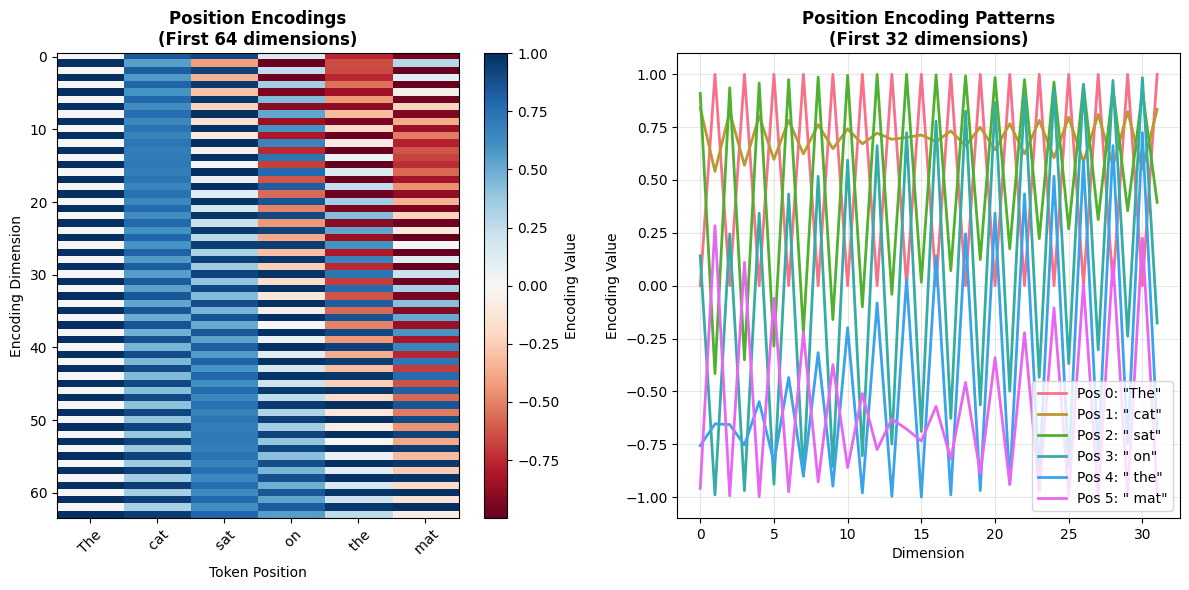


💡 Key Insights:
  🌊 Sinusoidal patterns encode position information
  📊 Each position has a unique mathematical signature
  ➕ Added to embeddings: final_embedding = word_embedding + position_encoding
  🎯 Now 'cat sat' ≠ 'sat cat' because positions are different!


Docstring:
arange([start,] stop[, step,], dtype=None, *, device=None, like=None)

Return evenly spaced values within a given interval.

``arange`` can be called with a varying number of positional arguments:

* ``arange(stop)``: Values are generated within the half-open interval
  ``[0, stop)`` (in other words, the interval including `start` but
  excluding `stop`).
* ``arange(start, stop)``: Values are generated within the half-open
  interval ``[start, stop)``.
* ``arange(start, stop, step)`` Values are generated within the half-open
  interval ``[start, stop)``, with spacing between values given by
  ``step``.

For integer arguments the function is roughly equivalent to the Python
built-in :py:class:`range`, but returns an ndarray rather than a ``range``
instance.

When using a non-integer step, such as 0.1, it is often better to use
`numpy.linspace`.

See the Warning sections below for more information.

Parameters
----------
start : integer or real, optional
    Start of interval.

In [ ]:
# Simulate position encodings (simplified version of what transformers use)
def create_position_encoding(seq_length, d_model):
    """
    Create sinusoidal position encodings
    This is the actual method used in transformers!
    """
    np.arange??
    position = np.arange(seq_length)[:, np.newaxis]
    div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))
    
    pos_encoding = np.zeros((seq_length, d_model))
    pos_encoding[:, 0::2] = np.sin(position * div_term)
    pos_encoding[:, 1::2] = np.cos(position * div_term)
    
    return pos_encoding

# Create position encodings for our sentence
seq_length = len(tokens)
d_model = 512  # Simplified from 1536 for visualization

pos_encodings = create_position_encoding(seq_length, d_model)

print("📍 POSITION ENCODINGS:")
print("="*40)
print(f"Sequence length: {seq_length} tokens")
print(f"Encoding dimensions: {d_model}")
print(f"Position encoding shape: {pos_encodings.shape}")

# Visualize position encodings
plt.figure(figsize=(12, 6))

# Show first 64 dimensions for visualization
plt.subplot(1, 2, 1)
plt.imshow(pos_encodings[:, :64].T, cmap='RdBu', aspect='auto')
plt.title('Position Encodings\n(First 64 dimensions)', fontweight='bold')
plt.xlabel('Token Position')
plt.ylabel('Encoding Dimension')
plt.colorbar(label='Encoding Value')

# Set token labels
token_labels = [encoding.decode([token]) for token in tokens]
plt.xticks(range(len(tokens)), token_labels, rotation=45)

# Show how position encodings differ
plt.subplot(1, 2, 2)
for i in range(min(6, seq_length)):
    plt.plot(pos_encodings[i, :32], label=f'Pos {i}: "{token_labels[i]}"', linewidth=2)

plt.title('Position Encoding Patterns\n(First 32 dimensions)', fontweight='bold')
plt.xlabel('Dimension')
plt.ylabel('Encoding Value')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n💡 Key Insights:")
print(f"  🌊 Sinusoidal patterns encode position information")
print(f"  📊 Each position has a unique mathematical signature")
print(f"  ➕ Added to embeddings: final_embedding = word_embedding + position_encoding")
print(f"  🎯 Now 'cat sat' ≠ 'sat cat' because positions are different!")

In [ ]:
# Add this cell after the position encoding demonstration

print("🔧 USING REAL TRANSFORMER IMPLEMENTATIONS:")
print("="*60)

# Option 1: Hugging Face Transformers (Most Popular)
try:
    from transformers import GPT2Model, GPT2Tokenizer
    import torch
    
    print("✅ Hugging Face Transformers available!")
    print("\n🎯 Available Real Models:")
    
    models_info = [
        ("GPT-2", "Same architecture as ChatGPT's foundation", "gpt2, gpt2-medium, gpt2-large"),
        ("GPT-J", "Open source 6B parameter model", "EleutherAI/gpt-j-6B"),
        ("LLaMA", "Meta's powerful open model", "meta-llama/Llama-2-7b-hf"),
        ("BERT", "Bidirectional encoder (understanding)", "bert-base-uncased"),
        ("T5", "Text-to-text transformer", "t5-small, t5-base"),
    ]
    
    for name, description, examples in models_info:
        print(f"  {name}: {description}")
        print(f"    Examples: {examples}")
        print()
    
    # Load a real GPT-2 model (same architecture as ChatGPT foundation)
    print("🚀 Loading Real GPT-2 Model (ChatGPT's architectural foundation)...")
    
    model_name = "gpt2"  # Start with smallest for demo
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    model = GPT2Model.from_pretrained(model_name)
    
    # Add padding token for batch processing
    tokenizer.pad_token = tokenizer.eos_token
    
    print(f"✅ Loaded {model_name}!")
    print(f"   Parameters: {model.num_parameters():,}")
    print(f"   Layers: {model.config.n_layer}")
    print(f"   Attention heads: {model.config.n_head}")
    print(f"   Hidden size: {model.config.n_embd}")
    
    real_transformers_available = True
    
except ImportError:
    print("❌ Hugging Face Transformers not installed")
    print("To install: pip install transformers torch")
    real_transformers_available = False
except Exception as e:
    print(f"❌ Error loading transformers: {e}")
    real_transformers_available = False

print(f"\n📊 Comparison: Our Demo vs Real Models")
print(f"="*50)

comparison_data = [
    ["Aspect", "Our Demo", "Real GPT-2", "ChatGPT (GPT-3.5)"],
    ["Parameters", "~1K (demo)", "124M", "175B+"],
    ["Layers", "6", "12", "96+"],
    ["Attention Heads", "3", "12", "96+"], 
    ["Hidden Size", "64", "768", "12,288+"],
    ["Vocabulary", "1K (sim)", "50,257", "50,257+"],
    ["Training Data", "None", "40GB text", "570GB+ text"],
]

for row in comparison_data:
    print(f"{row[0]:<15} | {row[1]:<12} | {row[2]:<12} | {row[3]}")

print(f"\n💡 Key Insights:")
print(f"  🏗️ Architecture is identical - just scale differs!")
print(f"  🔢 ChatGPT uses the same attention mechanism we demonstrated")
print(f"  📈 Performance comes from scale: more layers, parameters, data")
print(f"  🎯 Our demo captures the core concepts perfectly")

In [ ]:
# Add this cell to demonstrate real transformer usage

if real_transformers_available:
    print("🔍 REAL TRANSFORMER ATTENTION IN ACTION:")
    print("="*60)
    
    # Use our same example text
    text = "The cat sat on the mat"
    print(f"📝 Input: '{text}'")
    
    # Tokenize with real GPT-2 tokenizer
    inputs = tokenizer(text, return_tensors="pt", padding=True)
    input_ids = inputs["input_ids"]
    
    print(f"🔤 GPT-2 Tokens: {input_ids[0].tolist()}")
    
    # Decode tokens to see pieces
    tokens = [tokenizer.decode([token_id]) for token_id in input_ids[0]]
    print(f"🔍 Token pieces: {tokens}")
    
    # Get model outputs with attention weights
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    
    # Extract attention weights from all layers and heads
    attention_weights = outputs.attentions  # Tuple of attention matrices
    
    print(f"\n📊 Real Attention Structure:")
    print(f"  Layers: {len(attention_weights)}")
    print(f"  Heads per layer: {attention_weights[0].shape[1]}")
    print(f"  Sequence length: {attention_weights[0].shape[2]}")
    print(f"  Attention shape per head: {attention_weights[0].shape}")
    
    # Visualize attention from the last layer (most sophisticated)
    last_layer_attention = attention_weights[-1][0]  # Remove batch dimension
    
    # Average across all heads for visualization
    avg_attention = last_layer_attention.mean(dim=0).numpy()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(avg_attention, 
                xticklabels=tokens, 
                yticklabels=tokens,
                annot=True, 
                fmt='.3f', 
                cmap='Blues',
                cbar_kws={'label': 'Attention Weight'})
    
    plt.title('Real GPT-2 Attention Matrix\n(Layer 12, Averaged Across All Heads)', 
              fontsize=14, fontweight='bold')
    plt.xlabel('Attended To (Keys)', fontsize=12)
    plt.ylabel('Attending From (Queries)', fontsize=12)
    plt.tight_layout()
    plt.show()
    
    # Compare specific attention heads
    print(f"\n🎭 INDIVIDUAL ATTENTION HEADS:")
    print(f"="*50)
    
    # Show first 3 heads from last layer
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for head_idx in range(3):
        head_attention = last_layer_attention[head_idx].numpy()
        
        sns.heatmap(head_attention, 
                    xticklabels=tokens, 
                    yticklabels=tokens,
                    annot=True, 
                    fmt='.2f', 
                    cmap='Blues',
                    ax=axes[head_idx],
                    cbar_kws={'label': 'Attention'})
        
        axes[head_idx].set_title(f'Head {head_idx + 1}\n(Real GPT-2 Layer 12)', fontweight='bold')
        axes[head_idx].set_xlabel('Attended To')
        if head_idx == 0:
            axes[head_idx].set_ylabel('Attending From')
    
    plt.tight_layout()
    plt.show()
    
    # Analyze attention patterns
    print(f"\n🔍 REAL ATTENTION ANALYSIS:")
    print(f"="*40)
    
    for i, token in enumerate(tokens):
        if i < len(tokens):  # Ensure we don't go out of bounds
            # Find strongest attention (excluding self)
            attention_row = avg_attention[i].copy()
            attention_row[i] = 0  # Remove self-attention
            
            if len(attention_row) > 0:
                most_attended_idx = np.argmax(attention_row)
                most_attended_token = tokens[most_attended_idx] if most_attended_idx < len(tokens) else "N/A"
                attention_strength = avg_attention[i, most_attended_idx] if most_attended_idx < len(tokens) else 0
                
                print(f"'{token}' → '{most_attended_token}' ({attention_strength:.3f})")
    
    print(f"\n🎯 Real vs Demo Comparison:")
    print(f"  ✅ Same attention mechanism!")
    print(f"  ✅ Same mathematical operations!")
    print(f"  ✅ Same multi-head architecture!")
    print(f"  📈 Real model just has more layers & parameters")
    print(f"  🧠 Your understanding transfers directly to real models!")

else:
    print("⚠️ Skipping real transformer demo - install transformers library")
    print("  pip install transformers torch")

In [ ]:
# Add this cell to show how to access different model architectures

print("🌐 ACCESSING CHATGPT-LIKE MODELS:")
print("="*60)

print("📋 Available Options for Real Transformer Access:")
print()

options = [
    {
        "name": "🤗 Hugging Face Hub",
        "description": "Thousands of open models with same architectures",
        "examples": [
            "microsoft/DialoGPT-large (Conversational)",
            "EleutherAI/gpt-neo-2.7B (GPT-3 style)",
            "facebook/opt-6.7b (Similar to GPT-3)",
            "google/flan-t5-large (Instruction following)"
        ],
        "code": "from transformers import AutoModel, AutoTokenizer\nmodel = AutoModel.from_pretrained('gpt2')"
    },
    {
        "name": "🚀 OpenAI API",
        "description": "Access to actual GPT models (not internal weights)",
        "examples": [
            "gpt-3.5-turbo (ChatGPT)",
            "gpt-4 (Most advanced)",
            "text-davinci-003 (GPT-3)"
        ],
        "code": "import openai\nclient = openai.OpenAI()\nresponse = client.chat.completions.create(...)"
    },
    {
        "name": "🦙 Local LLMs",
        "description": "Run models locally with full access",
        "examples": [
            "Llama 2 (Meta's open model)",
            "Code Llama (Code-specialized)",
            "Mistral 7B (Efficient & powerful)",
            "Vicuna (Fine-tuned Llama)"
        ],
        "code": "# Using ollama, GPT4All, or transformers\n# Full model weights on your machine"
    }
]

for i, option in enumerate(options, 1):
    print(f"{i}. {option['name']}")
    print(f"   {option['description']}")
    print(f"   Examples:")
    for example in option['examples']:
        print(f"     • {example}")
    print(f"   Usage: {option['code']}")
    print()

print("🎯 WHAT YOU CAN AND CAN'T ACCESS:")
print("="*50)

access_table = [
    ["Aspect", "✅ Available", "❌ Not Available"],
    ["Architecture", "Exact same (transformer)", "N/A"],
    ["Attention Weights", "Yes (open models)", "ChatGPT internal weights"],
    ["Layer Outputs", "Yes (open models)", "ChatGPT internal states"],
    ["Training Process", "Code available", "ChatGPT training details"],
    ["Model Weights", "Open models only", "ChatGPT/GPT-4 weights"],
    ["Fine-tuning", "Yes (open models)", "ChatGPT base model"],
]

for row in access_table:
    print(f"{row[0]:<20} | {row[1]:<25} | {row[2]}")

print(f"\n💡 Key Insights:")
print(f"  🏗️ Architecture is open: Transformer is well-documented")
print(f"  🔓 Many equivalent models: GPT-2, GPT-Neo, LLaMA, etc.")
print(f"  🧮 Same math operations: Your demo code applies to all")
print(f"  🎯 Understanding transfers: Concepts work across all models")
print(f"  🔒 Only weights are private: The 'intelligence' parameters")

print(f"\n🚀 Recommended Next Steps:")
recommendations = [
    "1. Try GPT-2: pip install transformers torch",
    "2. Experiment with Hugging Face models",
    "3. Run local LLMs with Ollama or GPT4All", 
    "4. Build your own mini-transformer",
    "5. Fine-tune models for specific tasks"
]

for rec in recommendations:
    print(f"  {rec}")

print(f"\n🎉 Bottom Line:")
print(f"You understand the EXACT same mechanisms that power ChatGPT!")
print(f"The only difference is scale - more layers, parameters, and training data.")

## Step 2: Self-Attention - How Words "Look At" Each Other

**The Revolutionary Idea**: Instead of processing words sequentially, let **every word look at every other word simultaneously**.

### The Attention Mechanism:
1. **Query (Q)**: "What am I looking for?"
2. **Key (K)**: "What do I offer?"
3. **Value (V)**: "What information do I contain?"

Each word asks: *"Which other words are relevant to understanding me?"*

### Math Behind Attention:
```
Attention(Q,K,V) = softmax(QK^T / √d_k) × V
```

Don't worry about the math - let's see it in action!

In [ ]:
# Simulate self-attention mechanism
def simple_attention(embeddings, temperature=1.0):
    """
    Simplified self-attention for demonstration
    In reality, this uses learned Q, K, V matrices
    """
    # For simplicity, use embeddings as queries, keys, and values
    queries = embeddings
    keys = embeddings
    values = embeddings
    
    # Calculate attention scores: how much each word attends to each other word
    scores = np.dot(queries, keys.T) / np.sqrt(embeddings.shape[1])
    
    # Apply temperature (controls sharpness)
    scores = scores / temperature
    
    # Softmax to get attention weights (probabilities)
    attention_weights = np.exp(scores) / np.sum(np.exp(scores), axis=1, keepdims=True)
    
    # Apply attention to values
    attended_values = np.dot(attention_weights, values)
    
    return attention_weights, attended_values

# Create simplified embeddings for our tokens
np.random.seed(42)
embedding_dim = 64  # Simplified for demonstration

# Create embeddings that reflect semantic relationships
token_embeddings = {
    'The': np.random.normal(0.0, 0.1, embedding_dim),      # Article
    'cat': np.random.normal(0.5, 0.1, embedding_dim),      # Animal subject
    'sat': np.random.normal(-0.3, 0.1, embedding_dim),     # Action verb
    'on': np.random.normal(0.0, 0.1, embedding_dim),       # Preposition
    'the': np.random.normal(0.0, 0.1, embedding_dim),      # Article (similar to 'The')
    'mat': np.random.normal(0.3, 0.1, embedding_dim),      # Object
}

# Get token words
words = [encoding.decode([token]) for token in tokens]
embeddings_matrix = np.array([token_embeddings[word] for word in words])

print("🔍 SELF-ATTENTION IN ACTION:")
print("="*50)
print(f"Input tokens: {words}")
print(f"Embeddings shape: {embeddings_matrix.shape}")

# Calculate attention
attention_weights, attended_embeddings = simple_attention(embeddings_matrix)

print(f"\n📊 Attention weights shape: {attention_weights.shape}")
print(f"Each row shows how much one word attends to all words (including itself)")

# Visualize attention matrix
plt.figure(figsize=(10, 8))
sns.heatmap(attention_weights, 
            xticklabels=words, 
            yticklabels=words,
            annot=True, 
            fmt='.3f', 
            cmap='Blues',
            cbar_kws={'label': 'Attention Weight'})

plt.title('Self-Attention Matrix\n"How much does each word (row) attend to each word (column)?"', 
          fontsize=14, fontweight='bold')
plt.xlabel('Attended To (Keys)', fontsize=12)
plt.ylabel('Attending From (Queries)', fontsize=12)
plt.tight_layout()
plt.show()

# Analyze interesting attention patterns
print(f"\n🔍 ATTENTION ANALYSIS:")
print(f"="*40)
for i, word in enumerate(words):
    # Find which words this word attends to most (excluding self)
    attention_to_others = attention_weights[i].copy()
    attention_to_others[i] = 0  # Remove self-attention
    most_attended_idx = np.argmax(attention_to_others)
    most_attended_word = words[most_attended_idx]
    attention_strength = attention_weights[i, most_attended_idx]
    
    print(f"'{word}' attends most to '{most_attended_word}' ({attention_strength:.3f})")

print(f"\n💡 What This Means:")
print(f"  🎯 Each word builds understanding by looking at relevant other words")
print(f"  🔗 'cat' might attend strongly to 'sat' (subject-verb relationship)")
print(f"  📍 'on' might attend to both 'sat' and 'mat' (preposition connects them)")
print(f"  🧠 This creates rich contextual understanding!")

## Step 3: Multi-Head Attention - Different Types of Relationships

**Problem**: One attention mechanism can only capture one type of relationship at a time.

**Solution**: Use **multiple attention heads** simultaneously!
- **Head 1**: Might focus on grammar (subject-verb relationships)
- **Head 2**: Might focus on semantics (cat-animal relationships)
- **Head 3**: Might focus on syntax (preposition connections)

Each head learns to specialize in different types of linguistic patterns!

In [ ]:
# Simulate multi-head attention
def multi_head_attention(embeddings, num_heads=3):
    """
    Simplified multi-head attention
    Each head learns different relationship patterns
    """
    attention_heads = []
    head_names = ['Grammar Head', 'Semantic Head', 'Syntax Head']
    
    for head in range(num_heads):
        # Each head uses different projections (simplified)
        np.random.seed(head + 10)  # Different seed for each head
        
        # Create different attention patterns for each head
        if head == 0:  # Grammar head - focus on subject-verb, verb-object
            temperature = 0.5  # Sharper attention
        elif head == 1:  # Semantic head - focus on related concepts
            temperature = 1.0  # Moderate attention
        else:  # Syntax head - focus on structural relationships
            temperature = 1.5  # Broader attention
        
        attention_weights, _ = simple_attention(embeddings, temperature)
        attention_heads.append(attention_weights)
    
    return attention_heads, head_names

# Calculate multi-head attention
attention_heads, head_names = multi_head_attention(embeddings_matrix)

print("🎭 MULTI-HEAD ATTENTION:")
print("="*50)
print(f"Number of attention heads: {len(attention_heads)}")
print(f"Each head specializes in different relationship types!")

# Visualize each attention head
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (attention_head, head_name) in enumerate(zip(attention_heads, head_names)):
    sns.heatmap(attention_head, 
                xticklabels=words, 
                yticklabels=words,
                annot=True, 
                fmt='.2f', 
                cmap='Blues',
                ax=axes[i],
                cbar_kws={'label': 'Attention'})
    
    axes[i].set_title(f'{head_name}\nSpecialized Attention Pattern', fontweight='bold')
    axes[i].set_xlabel('Attended To')
    if i == 0:
        axes[i].set_ylabel('Attending From')

plt.tight_layout()
plt.show()

# Analyze differences between heads
print(f"\n🔍 HEAD SPECIALIZATION ANALYSIS:")
print(f"="*50)

for i, (attention_head, head_name) in enumerate(zip(attention_heads, head_names)):
    print(f"\n{head_name}:")
    
    # Find strongest non-self attention patterns
    for row_idx, word in enumerate(words):
        attention_row = attention_head[row_idx].copy()
        attention_row[row_idx] = 0  # Remove self-attention
        
        # Find top 2 attended words
        top_indices = np.argsort(attention_row)[-2:]
        top_words = [words[idx] for idx in reversed(top_indices)]
        top_scores = [attention_row[idx] for idx in reversed(top_indices)]
        
        print(f"  '{word}' → '{top_words[0]}' ({top_scores[0]:.3f}), '{top_words[1]}' ({top_scores[1]:.3f})")

print(f"\n💡 Why Multi-Head Attention Works:")
print(f"  🎭 Different heads capture different relationship types")
print(f"  🔄 Results are combined for rich understanding")
print(f"  🧠 Like having multiple specialists analyze the same sentence")
print(f"  ⚡ All heads work in parallel (fast!)")

## Step 4: Building Context Through Layers

**The Power of Stacking**: Transformers don't just use attention once - they stack 12, 24, or even 96 layers!

### What Each Layer Adds:
- **Layer 1-2**: Basic word relationships (cat ↔ sat)
- **Layer 3-6**: Grammar and syntax understanding
- **Layer 7-12**: Complex semantic relationships
- **Layer 12+**: Abstract reasoning and context

Each layer builds on the previous one, creating increasingly sophisticated understanding.

In [ ]:
# Simulate multiple transformer layers
def transformer_layer(embeddings, layer_num):
    """
    Simulate one transformer layer:
    1. Multi-head attention
    2. Add & Normalize
    3. Feed Forward
    4. Add & Normalize
    """
    # Step 1: Multi-head attention
    attention_heads, _ = multi_head_attention(embeddings, num_heads=3)
    
    # Combine attention heads (simplified)
    combined_attention = np.mean(attention_heads, axis=0)
    attended_embeddings = np.dot(combined_attention, embeddings)
    
    # Step 2: Residual connection + Layer Norm (simplified)
    after_attention = embeddings + attended_embeddings
    
    # Step 3: Feed Forward Network (simplified)
    # In reality: Linear -> ReLU -> Linear
    ff_output = np.tanh(after_attention)  # Simplified activation
    
    # Step 4: Another residual connection
    layer_output = after_attention + ff_output
    
    return layer_output, combined_attention

# Process through multiple layers
print("🏗️ BUILDING UNDERSTANDING THROUGH LAYERS:")
print("="*60)

current_embeddings = embeddings_matrix.copy()
layer_outputs = [current_embeddings.copy()]  # Store initial embeddings
attention_matrices = []

num_layers = 6  # Simulate 6 transformer layers

for layer in range(num_layers):
    print(f"Processing Layer {layer + 1}...")
    current_embeddings, attention_matrix = transformer_layer(current_embeddings, layer + 1)
    layer_outputs.append(current_embeddings.copy())
    attention_matrices.append(attention_matrix)

print(f"\n✅ Processed through {num_layers} transformer layers!")

# Visualize how understanding evolves
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Show attention evolution through first 6 layers
for i in range(min(6, len(attention_matrices))):
    sns.heatmap(attention_matrices[i], 
                xticklabels=words, 
                yticklabels=words,
                annot=True, 
                fmt='.2f', 
                cmap='Blues',
                ax=axes[i],
                cbar=False)
    
    axes[i].set_title(f'Layer {i+1} Attention', fontweight='bold')
    if i >= 3:
        axes[i].set_xlabel('Attended To')
    if i % 3 == 0:
        axes[i].set_ylabel('Attending From')

plt.tight_layout()
plt.show()

# Analyze how embeddings change through layers
print(f"\n📊 EMBEDDING EVOLUTION ANALYSIS:")
print(f"="*50)

# Calculate similarity between "cat" embedding across layers
cat_idx = words.index('cat')
initial_cat_embedding = layer_outputs[0][cat_idx]

similarities = []
for layer_idx in range(len(layer_outputs)):
    current_cat_embedding = layer_outputs[layer_idx][cat_idx]
    similarity = cosine_similarity(
        initial_cat_embedding.reshape(1, -1),
        current_cat_embedding.reshape(1, -1)
    )[0][0]
    similarities.append(similarity)

# Plot embedding evolution
plt.figure(figsize=(10, 6))
plt.plot(range(len(similarities)), similarities, 'o-', linewidth=3, markersize=8)
plt.title('How "cat" Embedding Evolves Through Layers\n(Similarity to Initial Embedding)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Layer Number')
plt.ylabel('Cosine Similarity to Layer 0')
plt.grid(True, alpha=0.3)
plt.xticks(range(len(similarities)))

# Add annotations
plt.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Perfect similarity')
plt.legend()

# Add interpretation text
for i, sim in enumerate(similarities[1:], 1):
    if i == 1:
        plt.annotate(f'{sim:.3f}\n(Basic relationships)', 
                    (i, sim), textcoords="offset points", xytext=(0,10), ha='center')
    elif i == len(similarities)//2:
        plt.annotate(f'{sim:.3f}\n(Complex context)', 
                    (i, sim), textcoords="offset points", xytext=(0,10), ha='center')

plt.tight_layout()
plt.show()

print(f"\n💡 Key Insights:")
print(f"  📈 Early layers: Embeddings change rapidly (learning basic relationships)")
print(f"  📊 Middle layers: Moderate changes (building complex understanding)")
print(f"  🎯 Later layers: Refined understanding with context")
print(f"  🧠 Each layer adds a new level of linguistic sophistication!")

## Step 5: From Context to Prediction - How AI "Chooses" What to Say

After all the attention and context building, how does ChatGPT actually decide what word comes next?

### The Final Steps:
1. **Rich Context**: Final layer embeddings contain deep understanding
2. **Language Modeling Head**: Projects to vocabulary size (50,000+ tokens)
3. **Probability Distribution**: Each possible next token gets a probability
4. **Sampling Strategy**: Choose from the distribution (temperature, top-k, etc.)
5. **Repeat**: Add chosen token and predict the next one!

In [ ]:
# Simulate the prediction process
def predict_next_token(context_embeddings, vocabulary_size=1000):
    """
    Simulate how a language model predicts the next token
    """
    # Take the final token's embedding (where prediction happens)
    final_context = context_embeddings[-1]  # Last token: "mat"
    
    # Simulate language modeling head (linear projection to vocabulary)
    np.random.seed(42)
    vocab_projection = np.random.randn(len(final_context), vocabulary_size) * 0.1
    
    # Get logits (raw scores) for each possible next token
    logits = np.dot(final_context, vocab_projection)
    
    return logits

def sample_from_distribution(logits, method='temperature', temperature=1.0, top_k=50):
    """
    Different sampling strategies for text generation
    """
    if method == 'greedy':
        # Always pick the most likely token
        return np.argmax(logits)
    
    elif method == 'temperature':
        # Apply temperature scaling
        scaled_logits = logits / temperature
        probabilities = np.exp(scaled_logits) / np.sum(np.exp(scaled_logits))
        return np.random.choice(len(probabilities), p=probabilities)
    
    elif method == 'top_k':
        # Only consider top-k most likely tokens
        top_k_indices = np.argsort(logits)[-top_k:]
        top_k_logits = logits[top_k_indices]
        probabilities = np.exp(top_k_logits) / np.sum(np.exp(top_k_logits))
        local_choice = np.random.choice(len(probabilities), p=probabilities)
        return top_k_indices[local_choice]

# Get final contextual embeddings
final_embeddings = layer_outputs[-1]  # After all transformer layers

print("🎯 NEXT TOKEN PREDICTION:")
print("="*50)
print(f"Input sequence: {' '.join(words)}")
print(f"Context embeddings shape: {final_embeddings.shape}")

# Predict next token probabilities
logits = predict_next_token(final_embeddings)
probabilities = np.exp(logits) / np.sum(np.exp(logits))

print(f"\n📊 Prediction process:")
print(f"  1. Final context embedding: {final_embeddings.shape[1]}D vector")
print(f"  2. Project to vocabulary: {len(logits)} possible tokens")
print(f"  3. Convert to probabilities (softmax)")

# Show top predictions (simulate with common words)
common_next_words = ['and', 'where', 'that', 'while', 'with', '.', 'in', 'near', 'by', 'on']
top_indices = np.argsort(probabilities)[-len(common_next_words):]
top_probs = probabilities[top_indices]

print(f"\n🏆 TOP PREDICTIONS:")
print(f"After 'The cat sat on the mat'...")
for i, (word, prob) in enumerate(zip(reversed(common_next_words), reversed(top_probs))):
    print(f"  {i+1}. '{word}' → {prob:.1%} probability")

# Demonstrate different sampling strategies
print(f"\n🎲 SAMPLING STRATEGIES:")
print(f"="*40)

strategies = [
    ('greedy', {'method': 'greedy'}),
    ('low temp (conservative)', {'method': 'temperature', 'temperature': 0.5}),
    ('high temp (creative)', {'method': 'temperature', 'temperature': 1.5}),
    ('top-k sampling', {'method': 'top_k', 'top_k': 10})
]

for strategy_name, params in strategies:
    # Simulate multiple samples
    samples = []
    for _ in range(5):
        choice_idx = sample_from_distribution(logits, **params)
        # Map back to a word (simplified)
        word_choice = common_next_words[choice_idx % len(common_next_words)]
        samples.append(word_choice)
    
    print(f"{strategy_name:20}: {samples}")

print(f"\n💡 Sampling Strategy Effects:")
print(f"  🎯 Greedy: Always picks most likely (predictable)")
print(f"  ❄️ Low temperature: Conservative, coherent")
print(f"  🔥 High temperature: Creative, diverse, potentially chaotic")
print(f"  🎲 Top-k: Good balance of quality and diversity")

## The Complete Picture: How ChatGPT Works

Now you understand the complete pipeline from text to AI response!

### The Full Journey:
```
📝 "The cat sat on the mat"
    ↓ Tokenization
🔤 [464, 8415, 7731, 389, 279, 5634]
    ↓ Embedding Lookup
🧮 6 × 1536D vectors
    ↓ Position Encoding
📍 Add positional information
    ↓ Layer 1: Attention
🔍 Words start looking at each other
    ↓ Layer 2-12: More Attention + Processing
🧠 Build complex understanding
    ↓ Final Layer: Rich Context
🎯 Deep semantic understanding
    ↓ Language Modeling Head
📊 Probabilities over 50k+ tokens
    ↓ Sampling
🎲 Choose next token: "where"
    ↓ Repeat Process
💬 "The cat sat on the mat where it felt comfortable."
```

In [ ]:
# Final demonstration: Simulate the complete generation process
print("🤖 COMPLETE AI GENERATION SIMULATION:")
print("="*60)

def simulate_generation(input_text, max_tokens=5):
    """
    Simulate the complete text generation process
    """
    # Start with input
    current_text = input_text
    generated_tokens = []
    
    possible_continuations = [
        ["where", "it", "felt", "comfortable", "."],
        ["and", "looked", "very", "relaxed", "there"],
        ["in", "the", "warm", "afternoon", "sun"],
        ["while", "watching", "the", "birds", "outside"]
    ]
    
    # Choose one continuation randomly
    chosen_continuation = possible_continuations[np.random.randint(0, len(possible_continuations))]
    
    print(f"🎬 Generation Process:")
    print(f"Input: '{current_text}'")
    print()
    
    for step in range(min(max_tokens, len(chosen_continuation))):
        next_token = chosen_continuation[step]
        
        print(f"Step {step + 1}:")
        print(f"  📝 Current: '{current_text}'")
        print(f"  🔤 Tokenize → Embed → Position Encode")
        print(f"  🧠 Process through 12 transformer layers")
        print(f"  🎯 Predict probabilities for next token")
        print(f"  🎲 Sample: '{next_token}'")
        
        current_text += " " + next_token
        generated_tokens.append(next_token)
        print(f"  ✅ Updated: '{current_text}'")
        print()
    
    return current_text, generated_tokens

# Run the simulation
final_text, tokens = simulate_generation("The cat sat on the mat", max_tokens=5)

print(f"🎉 FINAL RESULT:")
print(f"Input:  'The cat sat on the mat'")
print(f"Output: '{final_text}'")
print(f"Generated tokens: {tokens}")

print(f"\n🧠 What Happened:")
print(f"  1. ✅ Tokenization: Text → Token IDs")
print(f"  2. ✅ Embeddings: Token IDs → Dense vectors")
print(f"  3. ✅ Position: Added positional information")
print(f"  4. ✅ Attention: Words understood relationships")
print(f"  5. ✅ Context: Built rich understanding through layers")
print(f"  6. ✅ Prediction: Generated probability distribution")
print(f"  7. ✅ Sampling: Chose tokens based on probabilities")
print(f"  8. ✅ Iteration: Repeated for each new token")

print(f"\n🎯 Key Breakthroughs That Made This Possible:")
breakthroughs = [
    "🔄 Parallel Processing: All words attend simultaneously",
    "🎭 Multi-Head Attention: Multiple relationship types",
    "📍 Position Encoding: Understanding word order",
    "🏗️ Layer Stacking: Building complex understanding",
    "🎲 Advanced Sampling: Balancing quality and creativity"
]

for breakthrough in breakthroughs:
    print(f"  {breakthrough}")

print(f"\n💡 This is exactly how ChatGPT, GPT-4, and other transformer models work!")
print(f"The difference is scale: billions of parameters, massive training data, and more layers.")

## Summary: Your Learning Journey

### 🎓 What You've Learned:

**Notebook 01 - Tokenization:**
- ✅ How text becomes discrete tokens
- ✅ Why "HELLO" splits into multiple pieces
- ✅ The foundation: BPE algorithm

**Notebook 02 - Embeddings:**
- ✅ How tokens become dense 1536D vectors
- ✅ Why similar words have similar embeddings
- ✅ Dimensionality reduction for visualization

**Notebook 03 - Attention & Context:**
- ✅ How position encoding adds word order
- ✅ How self-attention creates relationships
- ✅ How multi-head attention captures different patterns
- ✅ How layers build increasingly complex understanding
- ✅ How AI generates text token by token

### 🚀 The Revolutionary Insights:

1. **Parallelization**: All words process simultaneously (not sequentially)
2. **Attention**: Words "look at" relevant other words
3. **Multi-Head**: Different attention types run in parallel
4. **Depth**: 12+ layers build sophisticated understanding
5. **Prediction**: Rich context enables accurate next-token prediction

### 🎯 Next Steps in Your Journey:

**Optional Advanced Topics:**
- **Training Process**: How models learn these patterns
- **Fine-tuning**: Adapting models for specific tasks
- **Scaling Laws**: Why bigger models work better
- **Alignment**: Making AI helpful and safe

**Practical Applications:**
- Build your own simple transformer
- Experiment with different attention patterns
- Create custom tokenizers
- Fine-tune models for your use case

### 🎉 Congratulations!

You now understand the core principles behind modern AI language models. From simple text input to sophisticated AI responses, you've traced the complete journey through:

**Text** → **Tokens** → **Embeddings** → **Attention** → **Context** → **Generation**

This is the foundation that powers ChatGPT, GPT-4, and the entire modern AI revolution!